### SET UP

In [1]:
# Cài Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Tải và giải nén Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

# Cài findspark
!pip install -q findspark

# Thiết lập biến môi trường cho JAVA và SPARK
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Khởi tạo findspark
import findspark
findspark.init()

# Import SparkSession và khởi tạo
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OnlineRestore") \
    .master("local[*]") \
    .getOrCreate()

# Kiểm tra phiên bản Spark
print("Spark version:", spark.version)


Spark version: 3.3.2


In [8]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
from functools import reduce

In [2]:
from google.colab import files
file= files.upload()

Saving OnlineRetail.csv to OnlineRetail.csv


### 2. Load data

In [3]:
df = spark.read.csv("OnlineRetail.csv", header=True, inferSchema=True)
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



#### 3. Data Profiling, Anomaly Detection and Data Cleaning

##### 3.1 Check the number of colummns and rows

In [4]:
# Check the number of columns and rows
print("Number of columns: ", len(df.columns))
print("Number of rows: ", df.count())

Number of columns:  8
Number of rows:  541909


##### 3.2 Abnormal 1: Check and correct Data Type

In [5]:
# Check schema
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
# Convert datatype of InvoiceDate to timestamp
df_cleaned = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))

# Re-check schema
df_cleaned.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### 3.3 Abnormal 2: Check and handle missing values

In [10]:
# Check for missing values in original data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



- Description: 1,454 --> remove since it is hard to guess the product description
- CustomerID: 135,080 --> might keep them, change null value into Unknown

In [11]:
# Delete the null values in Description
df_cleaned = df_cleaned.filter(df_cleaned.Description.isNotNull())

# Change the value in CustomerID into "Unknown" for null values
df_cleaned = df_cleaned.withColumn("CustomerID", when(df_cleaned.CustomerID.isNull(), "Unknown").otherwise(df_cleaned.CustomerID))

In [12]:
# Re-check for missing values in the cleaned data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



### 3.4 Abnormal 3: Check and handle duplicate rows

In [13]:
# Check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  5268


In [14]:
# Drop duplicate rows
df_cleaned = df_cleaned.dropDuplicates()

In [15]:
# Re-check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  0


### 3.5 Abnormal 4: Handle negative Quantity and UnitPrice

### Check the number of cancelled order: The InvoiceNo starts with C (has negative Quantity)

In [16]:
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of canceled orders: ", cancel.count())
cancel.show(5)

Number of canceled orders:  9251
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C536606|    20914|SET/5 RED RETROSP...|      -2|2010-12-02 09:10:00|     2.95|     14092|United Kingdom|
|  C537998|    22727|ALARM CLOCK BAKEL...|      -4|2010-12-09 11:42:00|     3.75|     17411|United Kingdom|
|  C538723|    22333|RETROSPOT PARTY B...|      -7|2010-12-14 11:12:00|     1.65|     12434|     Australia|
|  C538763|    22107|  PIZZA PLATE IN BOX|      -8|2010-12-14 11:33:00|     3.75|     17722|United Kingdom|
|  C539278|    22617|BAKING SET SPACEB...|      -6|2010-12-16 15:39:00|     4.95|     18269|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+-----------

### Check for invalid values in Quantity and UnitPrice:

- Quantity < 0
- UnitPrice < 0

In [17]:
# Quantity has negative value
negative_Quantity = df_cleaned.filter(col("Quantity") < 0).count()
print("Number of negative Quantity: ", negative_Quantity)
df_cleaned.filter(col("Quantity") < 0).select("InvoiceNo", "Quantity").show(5)

Number of negative Quantity:  9725
+---------+--------+
|InvoiceNo|Quantity|
+---------+--------+
|  C536606|      -2|
|  C537998|      -4|
|  C538723|      -7|
|  C538763|      -8|
|  C539278|      -6|
+---------+--------+
only showing top 5 rows



In [18]:
# UnitPrice has negative value
negative_UnitPrice = df_cleaned.filter(col("UnitPrice") < 0).count()
print("Number of negative UnitPrice: ", negative_UnitPrice)
df_cleaned.filter(col("UnitPrice") < 0).select("InvoiceNo", "UnitPrice").show(5)

Number of negative UnitPrice:  2
+---------+---------+
|InvoiceNo|UnitPrice|
+---------+---------+
|  A563187|-11062.06|
|  A563186|-11062.06|
+---------+---------+



- We can see that cancelled orders also have the negative Quantity.
- The dataset contains 9,251 cancelled orders, while 9,725 orders have a negative quantity.
- Therefore, in the Data Cleaning section, when we remove orders with negative quantities, we also remove the cancelled orders at the same time.

### Remove abnormal Quantity and UnitPrice

In [19]:
# Filter out negative Quantity and UnitPrice
df_cleaned = df_cleaned.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Check negative Quantity and UnitPrice again
print("Negative Quantity count:", df_cleaned.filter(col("Quantity") < 0).count())
print("Negative UnitPrice count:", df_cleaned.filter(col("UnitPrice") < 0).count())

# Check number of cancelled orders again
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of cancelled orders: ", cancel.count())

Negative Quantity count: 0
Negative UnitPrice count: 0
Number of cancelled orders:  0


### 3.6 Abnormal 5: Identify abnormal StockCode-Description pairs that are not actual products
- Check abnormal StockCode

In [20]:
excluded_stockcodes = ["POST", "DOT", "M", "C2", "BANK CHARGES","S", "B", "AMAZONFEE",
                       "gift_0001_10", "gift_0001_20","gift_0001_30","gift_0001_40","gift_0001_50"]

# Identify rows with exclued StockCode
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))

# Show distinct excluded StockCode - Description pairs
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+------------+----------------------------------+
|StockCode   |Description                       |
+------------+----------------------------------+
|POST        |POSTAGE                           |
|DOT         |DOTCOM POSTAGE                    |
|gift_0001_40|Dotcomgiftshop Gift Voucher �40.00|
|C2          |CARRIAGE                          |
|gift_0001_30|Dotcomgiftshop Gift Voucher �30.00|
|BANK CHARGES|Bank Charges                      |
|M           |Manual                            |
|AMAZONFEE   |AMAZON FEE                        |
|gift_0001_50|Dotcomgiftshop Gift Voucher �50.00|
|gift_0001_20|Dotcomgiftshop Gift Voucher �20.00|
|S           |SAMPLES                           |
|gift_0001_10|Dotcomgiftshop Gift Voucher �10.00|
|B           |Adjust bad debt                   |
+------------+----------------------------------+



### Handle abnormal StockCode and Description pairs that are not actual products

In [21]:
df_cleaned = df_cleaned.filter(~col("StockCode").isin(excluded_stockcodes))

In [22]:
# Re-check the abnormal stock code
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+---------+-----------+
|StockCode|Description|
+---------+-----------+
+---------+-----------+



### 4. Data cleaning results

In [23]:
# The number of rows before cleaning
rows_before_cleaning = df.count()
print(f"Number of rows before cleaning: {rows_before_cleaning}")

Number of rows before cleaning: 541909


In [24]:
# Check the number of rows after cleaning
rows_after_cleaning = df_cleaned.count()
print(f"Number of rows after cleaning: {rows_after_cleaning}")

Number of rows after cleaning: 522541


### 5. Feature Engineering

In [25]:
# Convert InvoiceDate data type to DateType
df_fe = df_cleaned.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "M/d/yyyy H:mm"))
df_fe.printSchema()
df_fe.show(5)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536415|    22951|60 CAKE CASES DOL...|       2| 2010-12-01|     0.55|     12838|United Kingdom|
|   536488|    22909|SET OF 20 VINTAGE...|       1| 2010-12-01|     0.85|     17897|United Kingdom|
|   536592|    22665|RECIPE BOX BLUE S...|       1| 2010-12-01|     5.91|   Unknown|United Kingdom|
|   536600|   84029G|KNITTED UNION FLA...|       6| 2010-12-02|  

In [26]:
# Get the max date of the dataset
max_date = df_fe.agg(max("InvoiceDate")).collect()[0][0]
max_date

datetime.date(2011, 12, 9)

In [27]:
# Calculate recency
recency_df = df_fe.groupBy("CustomerID").agg(
    datediff(lit(max_date), max("InvoiceDate")).alias("Recency")
)
recency_df.show(5)


+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    261|
|     15574|    177|
|     15555|     12|
|     15271|      7|
|     17714|    320|
+----------+-------+
only showing top 5 rows



In [28]:
# Calculate frequency (number of transactions per customer)
frequency_df = df_fe.groupBy("CustomerID").agg(
    count("InvoiceNo").alias("Frequency")
)
frequency_df.show(5)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     13610|      215|
|     15555|      885|
|     15271|      264|
|     15574|      152|
|     13282|       37|
+----------+---------+
only showing top 5 rows



In [29]:
# Calculate Monetary (Total money spent by customer)
monetary_df = df_fe.withColumn("TotalPrice", col("Quantity") * col("UnitPrice")) \
    .groupBy("CustomerID") \
    .agg(round(sum("TotalPrice"), 3).alias("Monetary"))
monetary_df.show(5)

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|     13610| 1082.33|
|     15555| 4791.87|
|     15271| 2493.34|
|     15574|  675.64|
|     13282| 1132.14|
+----------+--------+
only showing top 5 rows



In [30]:
# Join all RFM features
dfs = [recency_df, frequency_df, monetary_df]
rfm_df = reduce(lambda df1, df2: df1.join(df2, "CustomerID"), dfs)
rfm_df.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     13610|     12|      215| 1082.33|
|     15555|     12|      885| 4791.87|
|     15271|      7|      264| 2493.34|
|     15574|    177|      152|  675.64|
|     13282|     18|       37| 1132.14|
+----------+-------+---------+--------+
only showing top 5 rows



In [31]:
# Calculate the average of Recency, Frequency, and Monetary
rfm_df.select(
    mean("Recency").alias("Mean_Recency"),
    mean("Frequency").alias("Mean_Frequency"),
    mean("Monetary").alias("Mean_Monetary")
).show()

+-----------------+------------------+------------------+
|     Mean_Recency|    Mean_Frequency|     Mean_Monetary|
+-----------------+------------------+------------------+
|92.20530565167243|120.54002306805074|2363.8343420991937|
+-----------------+------------------+------------------+



In [32]:
# Define thresholds based on the mean values
recency_threshold = 95
frequency_threshold = 120

# Create a new column 'Churn' based on the thresholds
rfm_df = rfm_df.withColumn(
    "Churn",
    when((col("Recency") > recency_threshold) & (col("Frequency") <= frequency_threshold), 1).otherwise(0)
)

# Show the resulting DataFrame with Churn column
rfm_df.select("CustomerID", "Recency", "Frequency", "Monetary", "Churn").show()

+----------+-------+---------+--------+-----+
|CustomerID|Recency|Frequency|Monetary|Churn|
+----------+-------+---------+--------+-----+
|     13610|     12|      215| 1082.33|    0|
|     15555|     12|      885| 4791.87|    0|
|     15271|      7|      264| 2493.34|    0|
|     15574|    177|      152|  675.64|    0|
|     13282|     18|       37| 1132.14|    0|
|     14157|     19|       46|  424.89|    0|
|     16250|    261|       24|  389.44|    1|
|     12394|     63|       25| 1080.48|    0|
|     17686|      7|      286| 5739.46|    0|
|     16320|    172|       56| 1038.46|    1|
|     13865|     58|       30|  501.56|    0|
|     13772|     33|      173| 1122.63|    0|
|     17714|    320|       10|   153.0|    1|
|     13192|     95|       63|  911.94|    0|
|     18130|     15|       70| 1059.39|    0|
|     16504|     25|       83|  465.88|    0|
|     17506|     75|       14|   302.2|    0|
|     12847|     22|       84|  843.64|    0|
|     14887|     79|        6|  18

### Final Dataframe

- If you want to work with timestamp (yyyy-M-d H:mm:ss) data, please use the code: [df_cleaned.join()]
- If you want to work with date (only yyyy=M-d), please change the below code:[df_cleaned.join()] --> [df_fe.join()]

In [33]:
# Join churn label into transaction-level cleaned data
final_df = rfm_df.join(df_cleaned, on="CustomerID", how="left")
final_df.show()

+----------+-------+---------+--------+-----+---------+---------+--------------------+--------+-------------------+---------+-------+
|CustomerID|Recency|Frequency|Monetary|Churn|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|Country|
+----------+-------+---------+--------+-----+---------+---------+--------------------+--------+-------------------+---------+-------+
|     12394|     63|       25| 1080.48|    0|   552188|    22557|PLASTERS IN TIN V...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    22551|PLASTERS IN TIN S...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    21244|BLUE POLKADOT PLATE |       8|2011-05-06 14:01:00|     1.69|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    23256|CHILDRENS CUTLERY...|       8|2011-05-06 14:01:00|     4.15|Belgium|
|     12394|     63|       25| 1080.48|    0|   552188|    212

- For further steps after my parts, I got a few instruction for each role of the type of dataframe

- df: original raw dataframe
- df_cleaned: dataframe after data cleaning in part 3
- df_fe : dataframe where the InvoiceDate converted into Date formula.
- rfm_df : The RFM dataframe with columns [CustomerID, Recency, Frequency, Monetary, Churn]
- final_df (optional) : use this if you prefer working directly with the cleaned transactional data (df_cleaned) rather than the aggregated RFM data.

### Analysis Of Online Retail
- I used final_df with final_df is the rfm_df join with clean_df

### Overall RFM by churn

In [34]:
final_df.groupBy("Churn") \
    .agg(
        avg("Recency").alias("Avg_Recency"),
        avg("Frequency").alias("Avg_Frequency"),
        avg("Monetary").alias("Avg_Monetary"),
        countDistinct("CustomerID").alias("Num_Customers")
    ).show()


+-----+------------------+------------------+-----------------+-------------+
|Churn|       Avg_Recency|     Avg_Frequency|     Avg_Monetary|Num_Customers|
+-----+------------------+------------------+-----------------+-------------+
|    1|202.52458374142998|48.705330908073314| 805.675525675109|         1340|
|    0|17.887016593879288| 35979.75082476387|416483.0581520642|         2995|
+-----+------------------+------------------+-----------------+-------------+



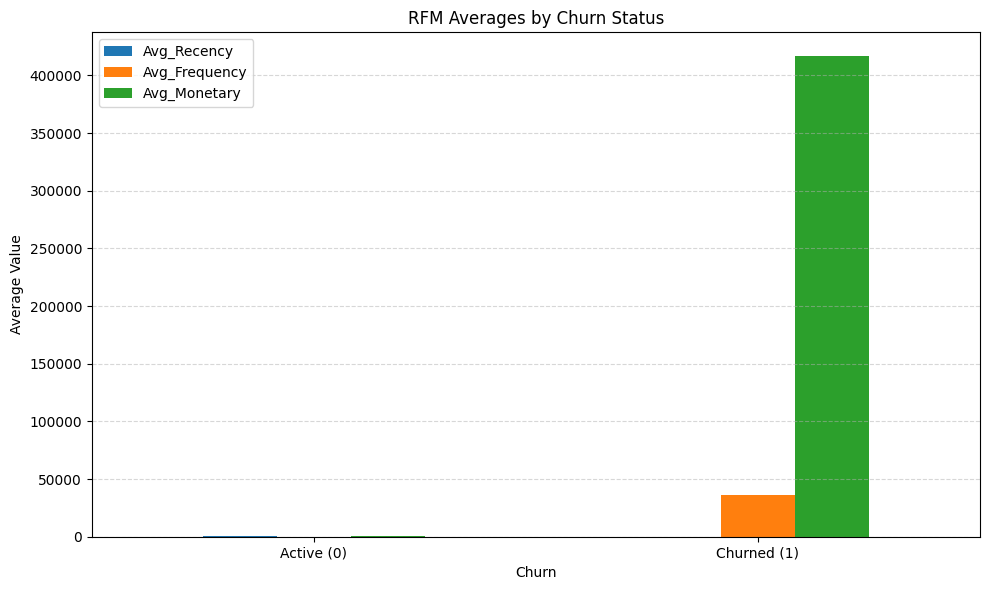

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

rfm_df = final_df.groupBy("Churn") \
    .agg(
        avg("Recency").alias("Avg_Recency"),
        avg("Frequency").alias("Avg_Frequency"),
        avg("Monetary").alias("Avg_Monetary"),
        countDistinct("CustomerID").alias("Num_Customers")
    ).toPandas()

rfm_df.set_index("Churn", inplace=True)
rfm_df[["Avg_Recency", "Avg_Frequency", "Avg_Monetary"]].plot(kind='bar', figsize=(10,6))
plt.title("RFM Averages by Churn Status")
plt.ylabel("Average Value")
plt.xticks(ticks=[0, 1], labels=["Active (0)", "Churned (1)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- Higher recency is a strong churn signal, on average, churn customers on average has 202 days since last purchase, while other customers who are not churn only has 17.2 days
- Churn customers only make 48 purchases-> New customers that only buy a few, then don't return -> Could be an isssue with customer retention
- Customers who are not churn made average 36.000 -> extremely high-> verify if a problem with calculation?
- High-spending customers tend to stay longer, as loyal customers bought nearly 416K-> focus on campaigns with VIP

### Churn Rate by Country

In [40]:
from pyspark.sql.functions import col, countDistinct

# Count customers per country and churn status
churn_by_country = final_df.groupBy("Country", "Churn") \
    .agg(countDistinct("CustomerID").alias("Num_Customers"))

# Pivot to get Active and Churned columns
churn_rate_country = churn_by_country.groupBy("Country") \
    .pivot("Churn", values=[0, 1]) \
    .sum("Num_Customers") \
    .withColumnRenamed("0", "Active_Customers") \
    .withColumnRenamed("1", "Churned_Customers") \
    .withColumn("Churn_Rate", col("Churned_Customers") / (col("Active_Customers") + col("Churned_Customers")))
print(churn_rate_country.show())


+------------------+----------------+-----------------+-------------------+
|           Country|Active_Customers|Churned_Customers|         Churn_Rate|
+------------------+----------------+-----------------+-------------------+
|            Sweden|               5|                3|              0.375|
|         Singapore|               1|             null|               null|
|           Germany|              72|               22|0.23404255319148937|
|               RSA|               1|             null|               null|
|            France|              64|               24| 0.2727272727272727|
|            Greece|               1|                3|               0.75|
|European Community|            null|                1|               null|
|           Belgium|              18|                7|               0.28|
|           Finland|              10|                2|0.16666666666666666|
|             Malta|               1|                1|                0.5|
|       Unsp

In [42]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
pdf = churn_rate_country.toPandas()
# show
print(pdf)

                 Country  Active_Customers  Churned_Customers  Churn_Rate
0                 Sweden               5.0                3.0    0.375000
1              Singapore               1.0                NaN         NaN
2                Germany              72.0               22.0    0.234043
3                    RSA               1.0                NaN         NaN
4                 France              64.0               24.0    0.272727
5                 Greece               1.0                3.0    0.750000
6     European Community               NaN                1.0         NaN
7                Belgium              18.0                7.0    0.280000
8                Finland              10.0                2.0    0.166667
9                  Malta               1.0                1.0    0.500000
10           Unspecified               2.0                3.0    0.600000
11                 Italy              10.0                4.0    0.285714
12                  EIRE              

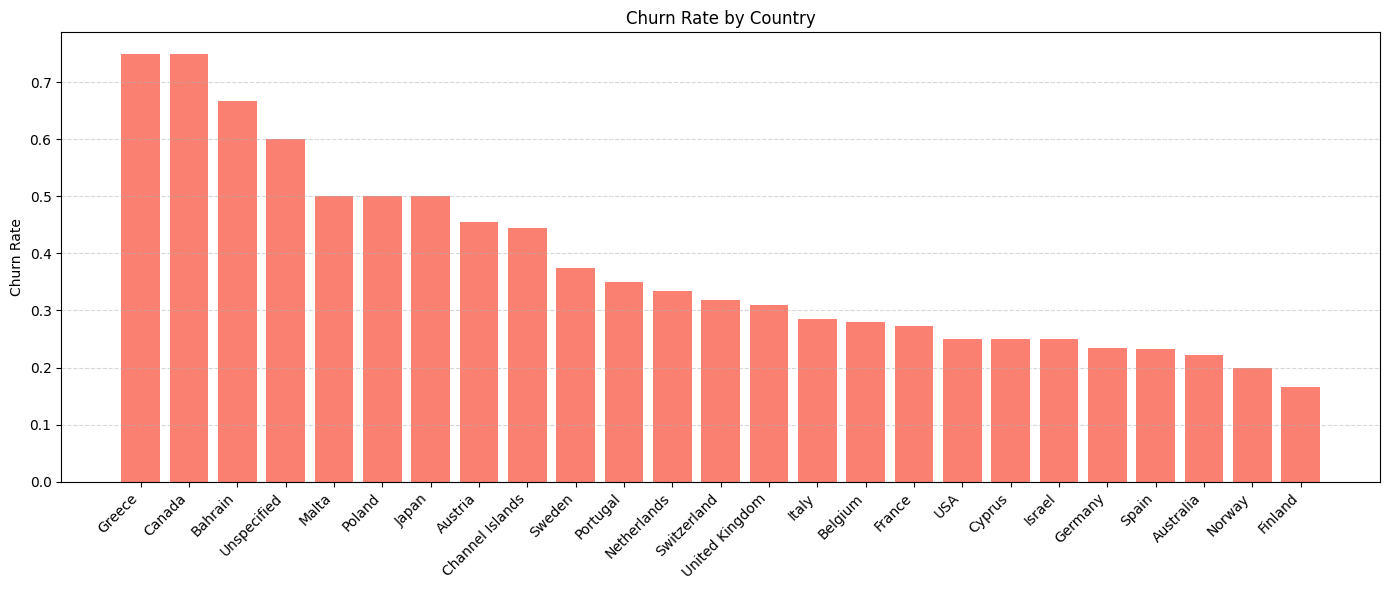

In [43]:
import matplotlib.pyplot as plt

# Drop countries with null churn rate (if any)
pdf = pdf.dropna(subset=["Churn_Rate"])

# Sort by churn rate
pdf = pdf.sort_values("Churn_Rate", ascending=False)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(pdf["Country"], pdf["Churn_Rate"], color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Country")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Churn Rate Breakdown By Countries
- United Kingdom — Largest Market: Customers: ~3,900 total (2706 active + 1211 churned) -> Main revenue driver, but churn rate is nearly 1/3 of total customers
- Countries like Singapore, Saudi Arabia, Lithuania have NaN churn rates due to missing active or churned customers
- Greece, Canada, Bahrain: Very high churn, but small customer base (1–3 active customers) — is this a outlier or data entry problem?
- Unspecified-> subscious entry-> maybe a data entry issue
- Austria: mid-size market, but notable churn rate
- Channel Islands: small size market, but notably high churn rate
- Finland, Norway, Germany, Spain: low churn rate, and mid-size market

### 2. Revenue per Customer by Country

In [37]:
from pyspark.sql.functions import sum as _sum

revenue_per_customer = final_df.withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .groupBy("Country", "Churn") \
    .agg(
        _sum("Revenue").alias("Total_Revenue"),
        countDistinct("CustomerID").alias("Num_Customers")
    ) \
    .withColumn("Revenue_per_Customer", col("Total_Revenue") / col("Num_Customers"))


In [44]:
revenue_pd = revenue_per_customer.select("Country", "Churn", "Revenue_per_Customer") \
    .toPandas()

In [46]:
print(revenue_pd)

           Country  Churn  Revenue_per_Customer
0      Unspecified      1            706.880000
1   United Kingdom      0           2944.012614
2          Germany      0           2540.891944
3        Australia      0          19420.135714
4           Norway      1            361.705000
..             ...    ...                   ...
58       Lithuania      1           1661.060000
59          Canada      0           2389.100000
60       Singapore      0           9120.390000
61             USA      0           1065.480000
62         Finland      1            870.875000

[63 rows x 3 columns]


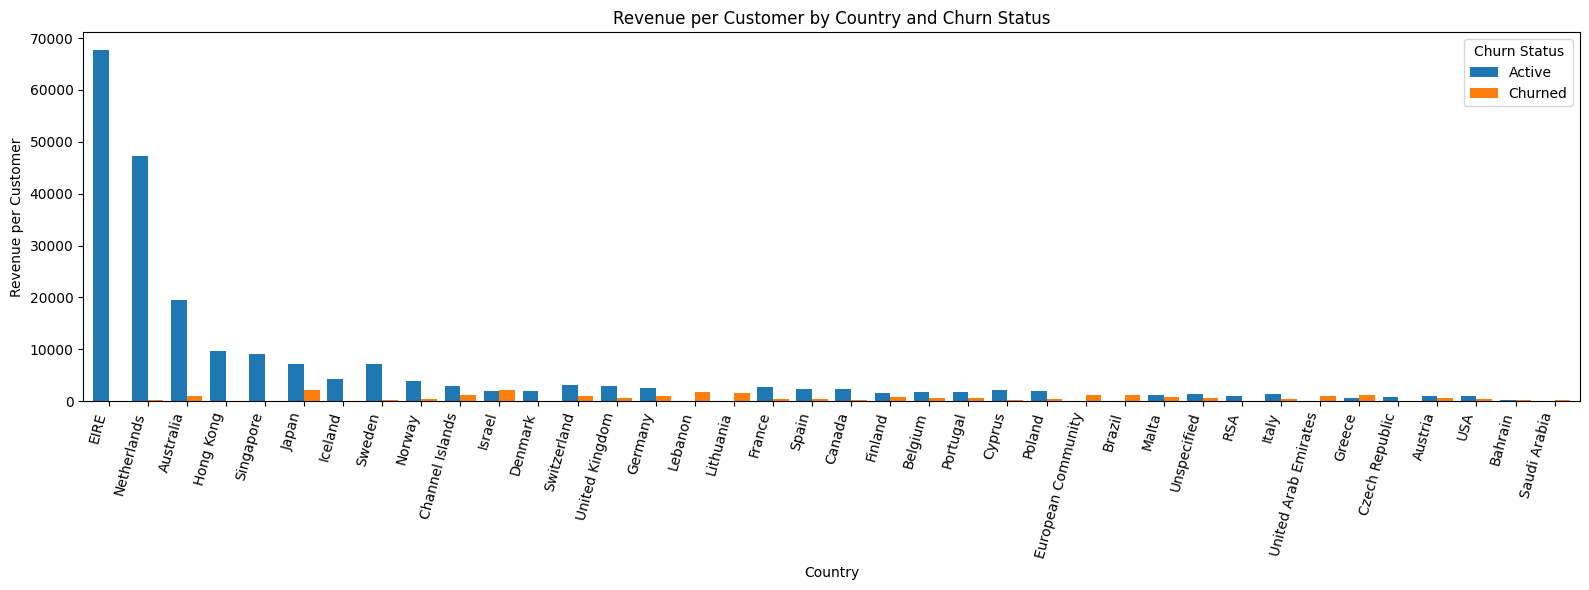

In [45]:
# Pivot to have Churned and Active side-by-side
pivot_df = revenue_pd.pivot(index="Country", columns="Churn", values="Revenue_per_Customer")
pivot_df = pivot_df.rename(columns={0: "Active", 1: "Churned"})

# Sort by total average revenue (optional)
pivot_df["Total_Avg"] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values("Total_Avg", ascending=False)

# Plotting
import matplotlib.pyplot as plt

pivot_df[["Active", "Churned"]].plot(kind="bar", figsize=(16, 6), width=0.8)
plt.title("Revenue per Customer by Country and Churn Status")
plt.xlabel("Country")
plt.ylabel("Revenue per Customer")
plt.xticks(rotation=75, ha='right')
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()

### Revenue Breakdown By Country

In [57]:
from pyspark.sql.functions import col, sum as _sum

# Compute revenue per country
revenue_by_country_df = final_df.withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .groupBy("Country") \
    .agg(_sum("Revenue").alias("Total_Revenue")) \
    .orderBy(col("Total_Revenue").desc())

# Convert to Pandas for plotting
revenue_pd = revenue_by_country_df.toPandas()


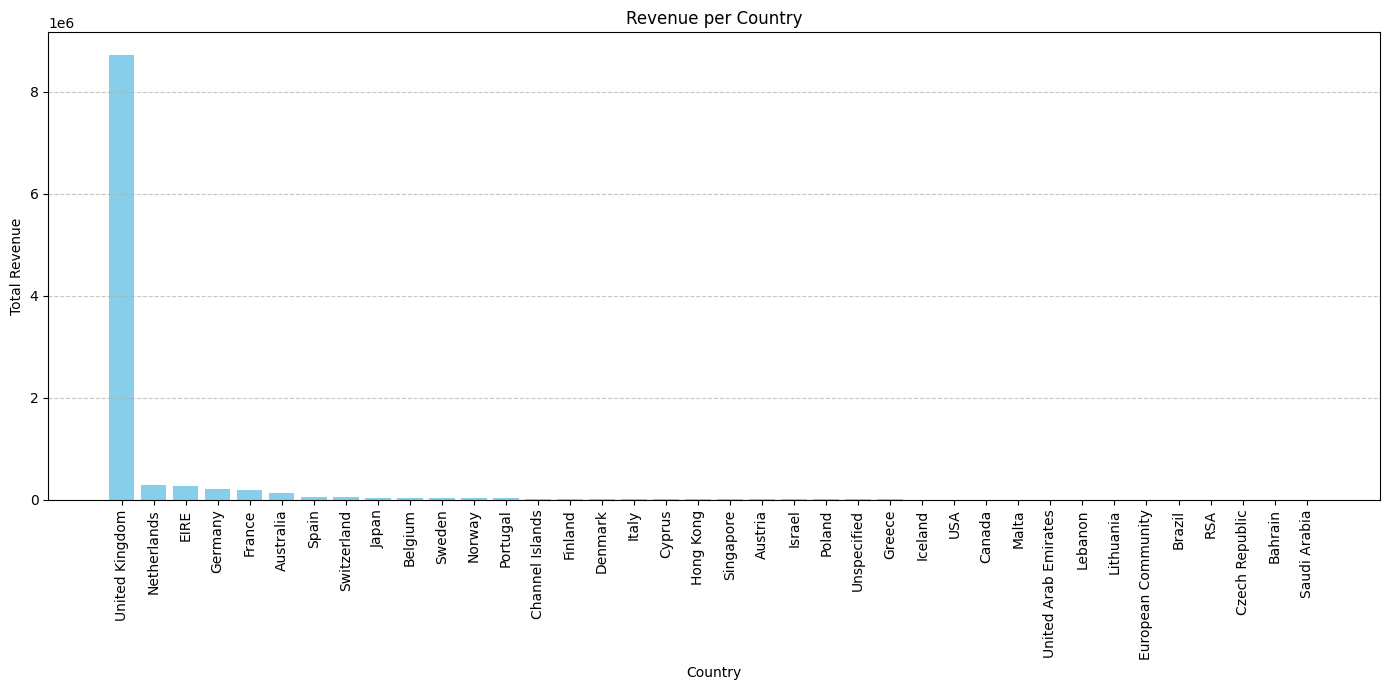

In [58]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(14, 7))
plt.bar(revenue_pd["Country"], revenue_pd["Total_Revenue"], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.title("Revenue per Country")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [53]:
from pyspark.sql.functions import col, sum as _sum

# Compute total revenue per country
top_countries_df = final_df.withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .groupBy("Country") \
    .agg(_sum("Revenue").alias("Total_Revenue")) \
    .orderBy(col("Total_Revenue").desc()) \
    .limit(3)

top_countries = [row["Country"] for row in top_countries_df.collect()]
print("Top 3 Countries by Revenue:", top_countries)


Top 3 Countries by Revenue: ['United Kingdom', 'Netherlands', 'EIRE']


In [54]:
from pyspark.sql.functions import month, year

# Filter only top 3 countries
filtered_df = final_df.filter(col("Country").isin(top_countries))

# Compute monthly revenue
monthly_revenue_trend = filtered_df.withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .withColumn("Year", year("InvoiceDate")) \
    .withColumn("Month", month("InvoiceDate")) \
    .groupBy("Year", "Month", "Country") \
    .agg(_sum("Revenue").alias("Total_Revenue")) \
    .orderBy("Year", "Month", "Country")


In [55]:
# Convert to Pandas
monthly_pd = monthly_revenue_trend.toPandas()

# Create Year-Month column for time series
monthly_pd["YearMonth"] = monthly_pd["Year"].astype(str) + "-" + monthly_pd["Month"].astype(str).str.zfill(2)

# Sort by time
monthly_pd = monthly_pd.sort_values(["Year", "Month"])


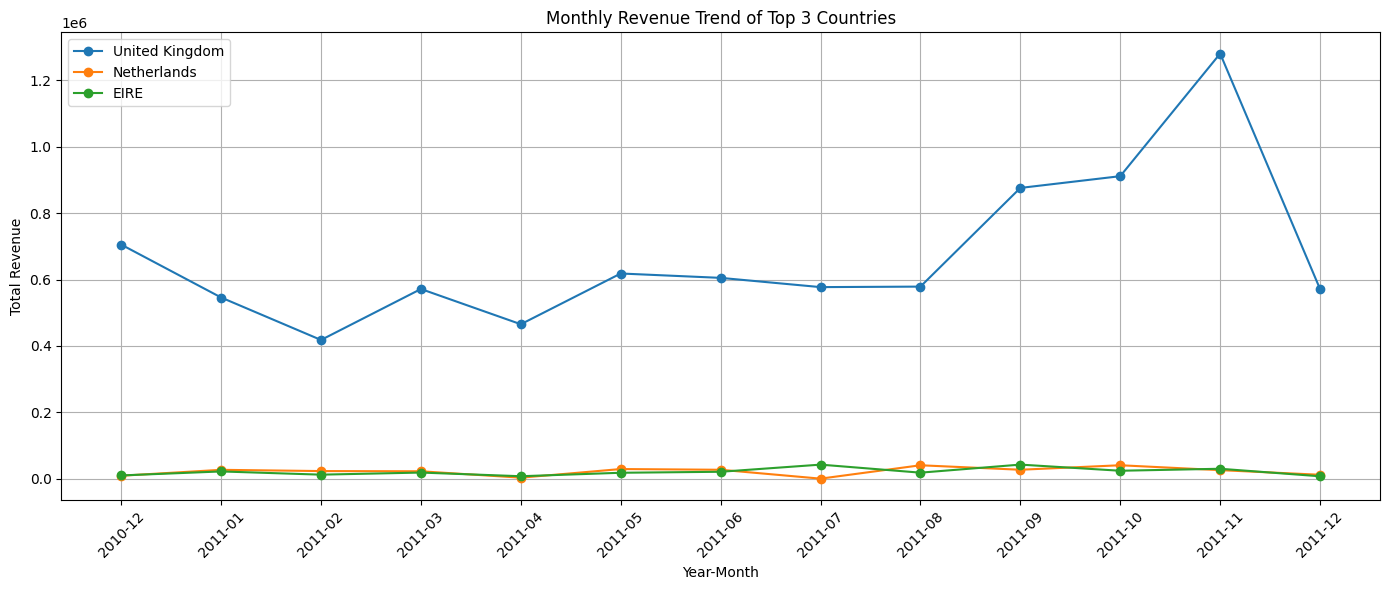

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for country in top_countries:
    country_data = monthly_pd[monthly_pd["Country"] == country]
    plt.plot(country_data["YearMonth"], country_data["Total_Revenue"], label=country, marker='o')

plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend of Top 3 Countries")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


### 3. Orders per Customer by Country

In [48]:
orders_per_customer = final_df.groupBy("Country", "Churn") \
    .agg(
        countDistinct("InvoiceNo").alias("Total_Orders"),
        countDistinct("CustomerID").alias("Num_Customers")
    ) \
    .withColumn("Orders_per_Customer", col("Total_Orders") / col("Num_Customers"))


In [49]:
orders_pd = orders_per_customer.select("Country", "Churn", "Orders_per_Customer") \
    .dropna() \
    .toPandas()

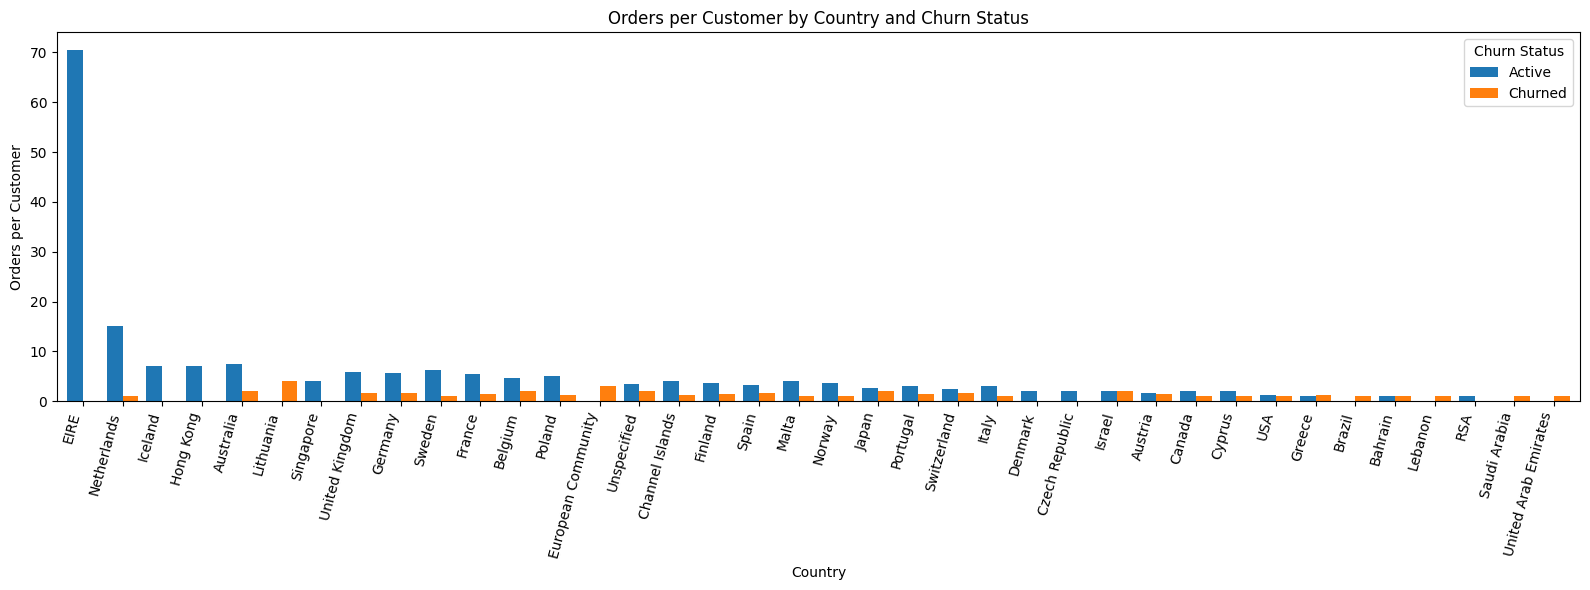

In [50]:

# Pivot to get Churned vs Active columns
pivot_orders = orders_pd.pivot(index="Country", columns="Churn", values="Orders_per_Customer")
pivot_orders = pivot_orders.rename(columns={0: "Active", 1: "Churned"})

# Optional: sort by total average orders
pivot_orders["Avg_Total"] = pivot_orders.mean(axis=1)
pivot_orders = pivot_orders.sort_values("Avg_Total", ascending=False)

# Plot
import matplotlib.pyplot as plt

pivot_orders[["Active", "Churned"]].plot(kind="bar", figsize=(16, 6), width=0.8)
plt.title("Orders per Customer by Country and Churn Status")
plt.xlabel("Country")
plt.ylabel("Orders per Customer")
plt.xticks(rotation=75, ha='right')
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()

### AOV

In [51]:
# Calculate AOV per country and churn
aov_df = final_df.withColumn("Revenue", col("Quantity") * col("UnitPrice")) \
    .groupBy("Country", "Churn") \
    .agg(
        _sum("Revenue").alias("Total_Revenue"),
        countDistinct("InvoiceNo").alias("Total_Orders")
    ) \
    .withColumn("AOV", col("Total_Revenue") / col("Total_Orders"))

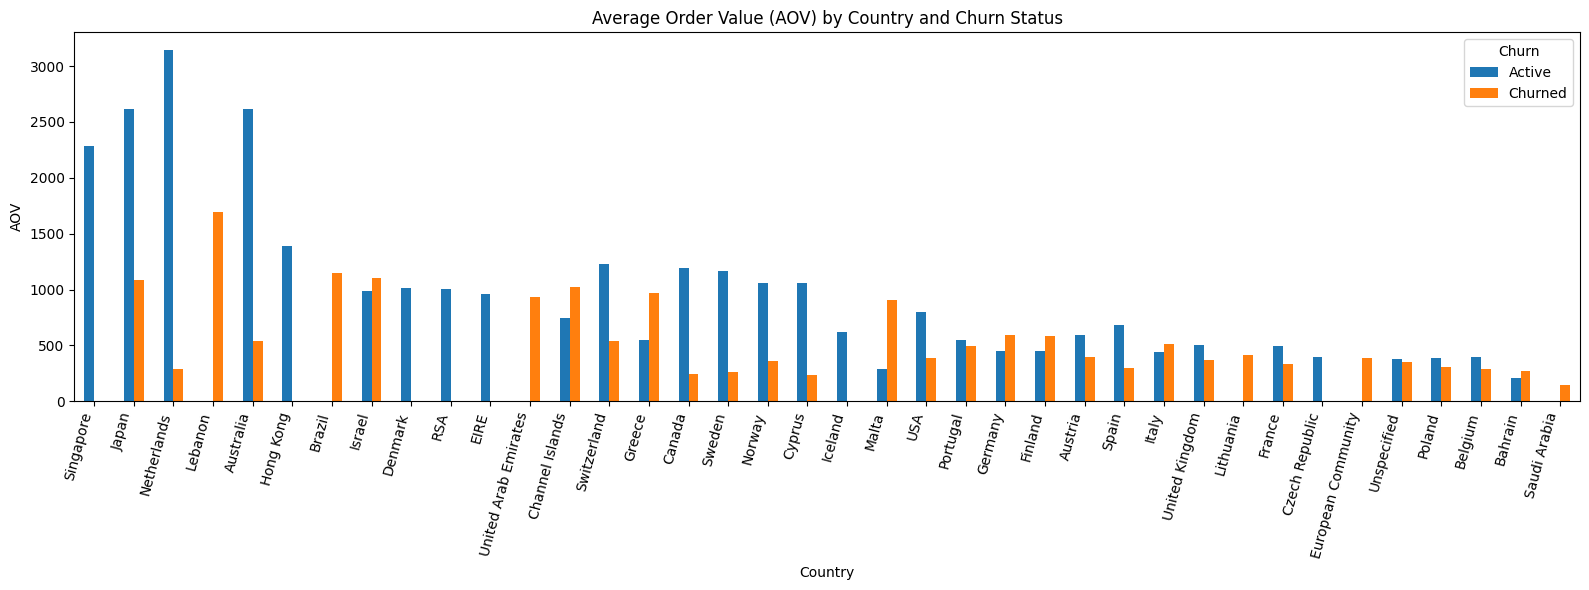

In [52]:
# Convert to Pandas
aov_pd = aov_df.select("Country", "Churn", "AOV").dropna().toPandas()

# Pivot for plotting
pivot_aov = aov_pd.pivot(index="Country", columns="Churn", values="AOV")
pivot_aov = pivot_aov.rename(columns={0: "Active", 1: "Churned"})
pivot_aov["Avg"] = pivot_aov.mean(axis=1)
pivot_aov = pivot_aov.sort_values("Avg", ascending=False)

# Plot
import matplotlib.pyplot as plt

pivot_aov[["Active", "Churned"]].plot(kind="bar", figsize=(16, 6))
plt.title("Average Order Value (AOV) by Country and Churn Status")
plt.ylabel("AOV")
plt.xlabel("Country")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

### AOV Breakdown:
- In contrast of Revenue, Singapore, Japan and Netheirlands is the top 3 country with highest AOV, while Saudi Abrabia, Bahrain, and Poland is top 3 lowest
- Japan while has high AOV, but also high churn rate